# Image Colorization using DC GAN Using 3 Network Architectures

## Project by : Deepthi D'Souza

The aim of this project is to perform image colorization using a Deep Convolutional Generative Adversarial Network (DCGAN). 
Image colorization is the process of adding color to grayscale images, which can be useful in various applications such as photography, restoration of old images, and enhancing visual content.

### Dataset Information:
* The dataset used in this project is the CIFAR-10 dataset, which consists of 60,000 32x32-pixel color images in 10 classes, with 6,000 images per class. 
* These images cover a wide range of objects and scenes, making it suitable for training and evaluating image processing models.




In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## DC GAN Network Architechture 1

### Step 1: Importing required Libraries

In [2]:
import os
import random
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D, Conv2DTranspose, AveragePooling2D,
                                     Dropout, Input, LeakyReLU, ReLU, Flatten, Dense, UpSampling2D)
from skimage.color import rgb2lab
from skimage.color import lab2rgb


In [ ]:
# Constants and hyperparameters
IMAGE_SIZE = 32
EPOCHS = 50
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100
WORKDIR = '/content/drive/'

### Step 2: Loading Dataset

In [4]:
# Load the CIFAR-10 dataset
(trainset, train_labels), (testset, test_label) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


 ### Step 3: Data Preprocessing

In [ ]:
def prepare_dataset(images, show_images=0):

    # Create empty lists
    X = list()
    Y = list()

    for image in images:

        # Normalize the array values to range [0,1]
        image = image / 255

        # Convert RGB image to LAB color space
        lab_image = rgb2lab(image)

        # Segregate the lightness (l) channel
        x = lab_image[:, :, 0]

        # Segregate the 'greenness to redness' (a) and 'blueness to yellowness' (b) channels
        y = lab_image[:, :, 1:]

        # Normalize the values to range [0,1]
        y = y / 128

        X.append(x.reshape(IMAGE_SIZE, IMAGE_SIZE, 1))
        Y.append(y)

        if show_images and random.randint(0, 1):
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.title('RGB image')
            plt.imshow(image)

            fig.add_subplot(1, 2, 2)
            plt.title('Normalized LAB image')
            plt.imshow(lab_image)
            plt.show()

            show_images -= 1

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)

    return X, Y

In [5]:
# Printinh dataset shape
print(f"Trainset: {trainset.shape}", end='')
print("         ============>         50,000 32x32 px images with 3 (RGB) channels")
print(f"Testset:  {testset.shape}", end='')
print("         ============>         10,000 32x32 px images with 3 (RGB) channels")

Trainset: (50000, 32, 32, 3)         ============>         50,000 32x32 px images with 3 (RGB) channels
Testset:  (10000, 32, 32, 3)         ============>         10,000 32x32 px images with 3 (RGB) channels


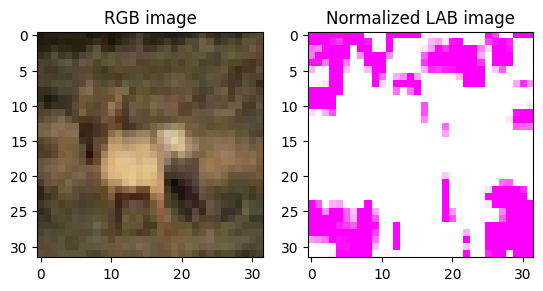

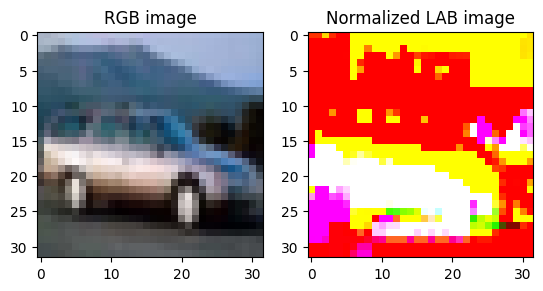

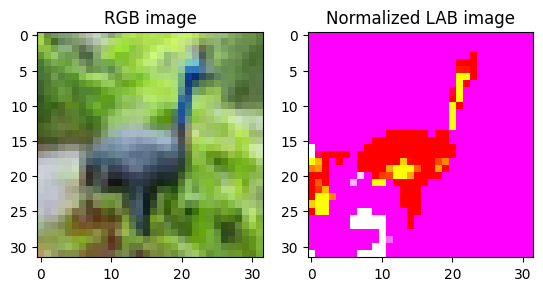

In [6]:
# Prepare the datasets (separate the LAB channels)
X_train, Y_train = prepare_dataset(trainset, show_images = 3)
X_test, Y_test = prepare_dataset(testset)

# Get the slices of arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Shuffle
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Step 4: Model Building

### Step 5: Building Generator Model Architecture

In [7]:
class GeneratorModel(tf.keras.Model):
    def __init__(self):
        super(GeneratorModel, self).__init__()

        self.conv1 = Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
        self.conv2 = Conv2D(64, (3, 3), padding='same', strides=2, activation='relu')
        self.batchnorm1 = BatchNormalization()
        self.conv3 = Conv2D(128, (3, 3), padding='same', activation='relu', strides=2)
        self.conv4 = Conv2D(128, (3, 3), padding='same', activation='relu')
        self.batchnorm2 = BatchNormalization()
        self.conv5 = Conv2D(256, (3, 3), padding='same')
        self.activation = Activation('relu')
        self.batchnorm3 = BatchNormalization()
        self.upsampling1 = UpSampling2D(size=(2, 2))
        self.conv6 = Conv2D(128, (3, 3), padding='same', activation='relu')
        self.batchnorm4 = BatchNormalization()
        self.upsampling2 = UpSampling2D(size=(2, 2))
        self.conv7 = Conv2D(64, (3, 3), padding='same', activation='relu')
        self.batchnorm5 = BatchNormalization()
        self.conv8 = Conv2D(32, (3, 3), padding='same', activation='relu')
        self.conv9 = Conv2D(2, (3, 3), padding='same')
        self.batchnorm6 = BatchNormalization()
        self.activation2 = Activation('tanh')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.batchnorm1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.batchnorm2(x)
        x = self.conv5(x)
        x = self.activation(x)
        x = self.batchnorm3(x)
        x = self.upsampling1(x)
        x = self.conv6(x)
        x = self.batchnorm4(x)
        x = self.upsampling2(x)
        x = self.conv7(x)
        x = self.batchnorm5(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.batchnorm6(x)
        x = self.activation2(x)
        return x


### Step 6: Building Discriminator Model Architecture

In [8]:
class DiscriminatorModel(Sequential):
    def __init__(self):
        super(DiscriminatorModel, self).__init__()

        self.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
        self.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
        self.add(AveragePooling2D(pool_size=(2, 2)))
        self.add(Dropout(0.25))

        self.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        self.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        self.add(AveragePooling2D(pool_size=(2, 2)))
        self.add(Dropout(0.25))

        self.add(Flatten())
        self.add(Dense(512))
        self.add(LeakyReLU(0.2))
        self.add(BatchNormalization())
        self.add(Dropout(0.5))
        self.add(Dense(1))
        self.add(Activation('sigmoid'))


In [9]:
# Downsample the images
def downsample(filters, kernel_size, apply_batchnorm=True):

    # Define the initializer for the convolutional layer weights
    initializer = tf.random_uniform_initializer(0, 0.02)

    # Create a Sequential model for downsampling
    model = Sequential()

    # Add a convolutional layer with specified filters, kernel size, and strides
    model.add(Conv2D(filters, kernel_size, strides=2, padding='same',
                     kernel_initializer=initializer, use_bias=False))

    # Apply optional BatchNormalization
    if apply_batchnorm:
        model.add(BatchNormalization())

    # Add LeakyReLU layer
    model.add(LeakyReLU())

    return model

# Upsample the images
def upsample(filters, kernel_size, apply_dropout=False):

    # Define the initializer for the convolutional layer weights
    initializer = tf.random_uniform_initializer(0, 0.02)

    # Create a Sequential model for upsampling
    model = Sequential()

    # Add a convolutional layer with specified filters, kernel size, and strides
    model.add(Conv2DTranspose(filters, kernel_size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))

    # Apply BatchNormalization
    model.add(BatchNormalization())

    # Add optional Dropout layer
    if apply_dropout:
        model.add(Dropout(0.5))

    # Add ReLU layer
    model.add(ReLU())

    return model

In [10]:
# Define the Autoencoder Generator Model Architecture
class AutoencoderGeneratorModel(Model):

    def __init__(self):

        super(AutoencoderGeneratorModel, self).__init__()

        # Define input layer
        self.inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

        # Define downsampling layers
        self.downstack = [
            downsample(32, 4, apply_batchnorm=False),
            downsample(64, 4),
            downsample(128, 4),
            downsample(256, 4),
            downsample(256, 4)
        ]

        # Define upsampling layers
        self.upstack = [
            upsample(256, 4, apply_dropout=True),
            upsample(128, 4),
            upsample(64, 4),
            upsample(32, 4),
        ]

        # Define output layer
        initializer = tf.random_uniform_initializer(0, 0.02)
        self.output_layer = Conv2DTranspose(2, 3, strides=2, padding='same',
                                            kernel_initializer=initializer,
                                            activation='tanh')

    def call(self, image):

        # Downsample the image
        skips = []
        for downsample_image in self.downstack:
            image = downsample_image(image)
            skips.append(image)

        # Reverse the skips list and exclude the last element
        skips = reversed(skips[:-1])

        # Upsample the image
        for upsample_image, skip in zip(self.upstack, skips):
            image = upsample_image(image)
            image = tf.concat([image, skip], axis=-1)

        # Apply the output layer
        image = self.output_layer(image)
        return image


### Step 7: Model Training

In [11]:
# Set lambda value as L1-loss multiplier and define the loss function
LAMBDA = 100
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Calculate discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):

    # For the real output, compare it with a tensor of ones
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)

    # For the generated output, compare it with a tensor of zeros
    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)

    # Compute the total discriminator loss
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

# Calculate generator loss
def generator_loss(disc_generated_output, gen_output, target):

    # For the generated output, compare it with a tensor of ones
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)

    # Calculate the L1 loss as the mean absolute difference between the target and the generated output
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    # Compute the total generator loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

In [12]:
generator = AutoencoderGeneratorModel()
discriminator = DiscriminatorModel()

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [13]:
def train_step(input_image, target):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # Generate the image
        gen_output = generator(input_image, training=True)

        # Fetch the real and generated outputs
        disc_real_output = discriminator(tf.keras.layers.concatenate([input_image, target]), training=True)
        disc_generated_output = discriminator(tf.keras.layers.concatenate([input_image, gen_output]), training=True)

        # Compute the generator and discriminator losses
        gen_total_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Compute gradients
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize using the gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, disc_loss

In [14]:
# Lists to store loss values
gen_losses = []
disc_losses = []

# Training loop
for epoch in range(EPOCHS):
    gen_loss_total = disc_loss_total = 0
    for input_image, target in train_dataset:
        gen_loss, disc_loss = train_step(input_image, target)
        gen_loss_total += gen_loss
        disc_loss_total += disc_loss

    # Calculate average loss per batch
    gen_loss_avg = gen_loss_total / BATCH_SIZE
    disc_loss_avg = disc_loss_total / BATCH_SIZE

    # Append losses to lists
    gen_losses.append(gen_loss_avg)
    disc_losses.append(disc_loss_avg)

    print(f'Epoch {epoch + 1}: gen loss: {gen_loss_total / BATCH_SIZE}, disc loss: {disc_loss_total / BATCH_SIZE}')

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1: gen loss: 37.675933837890625, disc loss: 5.265470504760742
Epoch 2: gen loss: 23.32027244567871, disc loss: 4.709706783294678
Epoch 3: gen loss: 22.869234085083008, disc loss: 4.434586048126221
Epoch 4: gen loss: 22.532386779785156, disc loss: 4.317747116088867
Epoch 5: gen loss: 22.26020622253418, disc loss: 4.265674114227295
Epoch 6: gen loss: 22.079601287841797, disc loss: 4.250338554382324
Epoch 7: gen loss: 21.93680763244629, disc loss: 4.242454528808594
Epoch 8: gen loss: 21.83433723449707, disc loss: 4.24003791809082
Epoch 9: gen loss: 21.730443954467773, disc loss: 4.239625453948975
Epoch 10: gen loss: 21.64175796508789, disc loss: 4.239631652832031
Epoch 11: gen loss: 21.54920196533203, disc loss: 4.238771915435791
Epoch 12: gen loss: 21.483259201049805, disc loss: 4.2397990226745605
Epoch 13: gen loss: 21.399568557739258, disc loss: 4.239625930786133
Epoch 14: gen loss: 21.32110595703125, disc loss: 4.2388997077941895
Epoch 15: gen loss: 21.230356216430664, disc loss

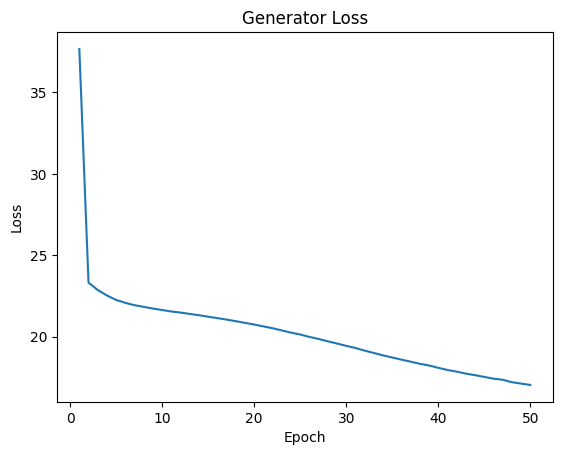

In [16]:
# Plot the generator loss graph
plt.plot(range(1, EPOCHS + 1), gen_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.show()

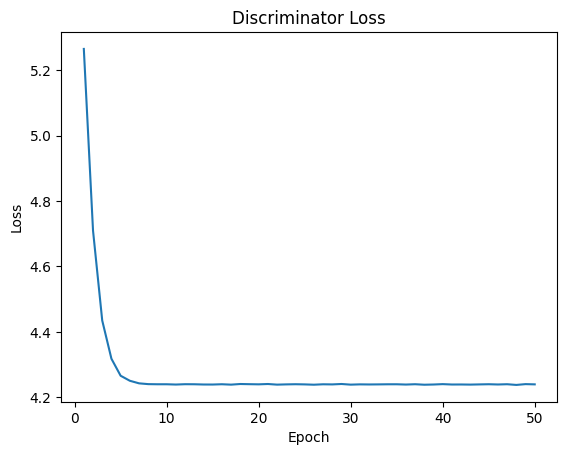

In [17]:
# Plot the discriminator loss graph
plt.plot(range(1, EPOCHS + 1), disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.show()

### Step 8: Model Test

In [18]:
# Create lists for original and generated images
Y_hat = generator(X_test)

original_images = list()
grayscale_images = list()
predicted_images = list()

for idx, (x, y, y_hat) in enumerate(zip(X_test, Y_test, Y_hat)):

    # Original RGB image
    orig_lab = np.dstack((x, y * 128))
    orig_rgb = lab2rgb(orig_lab)
    original_images.append(orig_rgb)

    # Grayscale version of the original image
    grayscale_lab = np.dstack((x, np.zeros((IMAGE_SIZE, IMAGE_SIZE, 2))))
    grayscale_rgb = lab2rgb(grayscale_lab)
    grayscale_images.append(grayscale_rgb)

    # Colorized image
    predicted_lab = np.dstack((x, y_hat * 128))
    predicted_rgb = lab2rgb(predicted_lab)
    predicted_images.append(predicted_rgb)


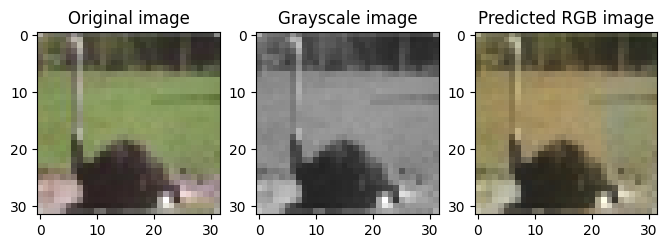

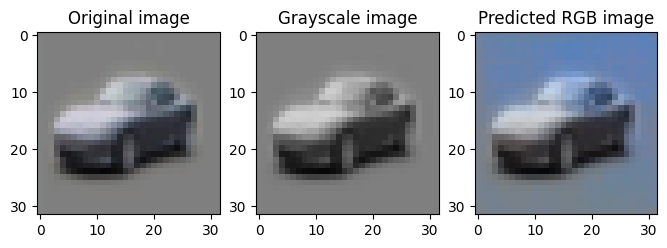

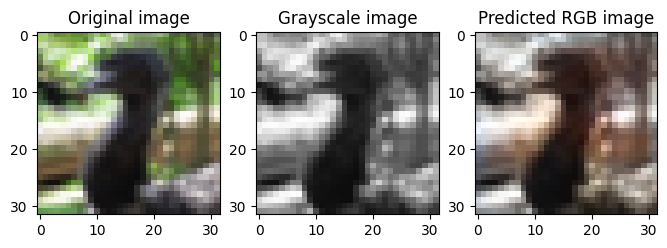

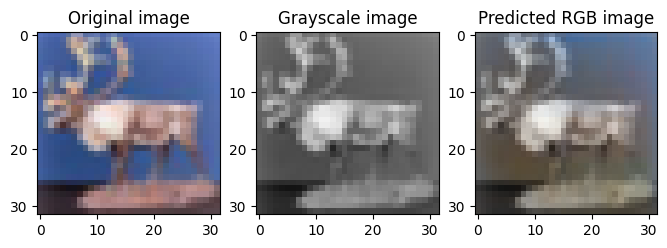

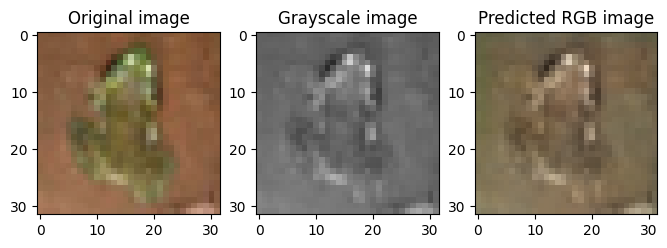

In [19]:
# Display original, grayscale, and generated images
for idx in random.sample(range(len(original_images)), 5):
    fig = plt.figure(figsize=(8, 6))
    fig.add_subplot(1, 3, 1)
    plt.title('Original image')
    plt.imshow(original_images[idx])


    fig.add_subplot(1, 3, 2)
    plt.title('Grayscale image')
    plt.imshow(grayscale_images[idx])


    fig.add_subplot(1, 3, 3)
    plt.title('Predicted RGB image')
    plt.imshow(predicted_images[idx])


## DC GAN Network Architecture 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 1: Importing Required Libraries

In [ ]:
import os
import numpy as np

from matplotlib import image
from matplotlib import pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

### Step 2: Data Loading and Data Preparation

In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Define parameters
img_size = 32
batch_size = 32
dataset_split = len(x_train)  # Split the entire dataset

# Preprocess the CIFAR-10 dataset
x = []
y = []
for i in range(dataset_split):
    rgb_image = Image.fromarray(x_train[i]).resize((img_size, img_size))
    rgb_img_array = np.asarray(rgb_image) / 255.0
    gray_image = rgb_image.convert('L')
    gray_img_array = np.asarray(gray_image).reshape((img_size, img_size, 1)) / 255.0
    x.append(gray_img_array)
    y.append(rgb_img_array)

# Train-test splitting
X_train, X_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(np.array(X_test), np.array(y_test), test_size=0.5)

print("X train:",X_train.shape)
print("y train:",y_train.shape)
print("X val:",X_val.shape)
print("y val:",y_val.shape)
print("X test:",X_test.shape)
print("y test:",y_test.shape)


# Construct tf.data.Dataset object
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

170498071/170498071 [==============================] - 2s 0us/step
X train: (35000, 32, 32, 1)
y train: (35000, 32, 32, 3)
X val: (7500, 32, 32, 1)
y val: (7500, 32, 32, 3)
X test: (7500, 32, 32, 1)
y test: (7500, 32, 32, 3)


### Step 3: GAN Model Definition

In [ ]:
def generator_model():

    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model


In [ ]:
def discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1, padding='same', activation='relu' , input_shape=( 32 , 32 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 5, 5 ) , strides=1, padding='same',activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, padding='same', activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, padding='same', activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, padding='same', activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, padding='same',activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, padding='same',activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, padding='same',activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' )
    ]
    model = tf.keras.models.Sequential( layers )
    return model




### Step 4: Defining Loss

In [ ]:
generator = generator_model()
discriminator = discriminator_model()

# Defining Loss functions and mse
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

# Defining generator and discriminator optimizer
generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

# Defining generator and discriminator loss
def discriminator_loss(real_img, fake_img):
    real_loss = cross_entropy(tf.ones_like(real_img) - tf.random.uniform( shape=real_img.shape , maxval=0.1 ) , real_img)
    fake_loss = cross_entropy(tf.zeros_like(fake_img) + tf.random.uniform( shape=fake_img.shape , maxval=0.1  ) , fake_img)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_img , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_img , real_y )


### Step 5: Training the model

In [ ]:
num_epochs = 50
t_gen_loss = []
t_disc_loss = []

v_gen_loss = []
v_disc_loss = []

for each_epoch in range(1, num_epochs+1):
    print("Epoch:", each_epoch, "/", num_epochs)

    # Training loop
    for (x_input, y_real) in train_dataset:
        # train_step(x_input, y_real)
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate an image
            generated_images = generator(x_input, training=True)

            real_output = discriminator(y_real, training=True)
            generated_output = discriminator(generated_images, training=True)

            # L2 Loss
            gen_loss = generator_loss(generated_images, y_real)

            # Log loss for the discriminator
            disc_loss = discriminator_loss(real_output, generated_output)

        # Compute the gradients
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # Optimize with Adam
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # # Update accuracy metric on CPU
        # with tf.device('/CPU:0'):
        #     accuracy.update_state(tf.squeeze(y_real), tf.squeeze(generated_images))

    # Print generator loss, discriminator loss, and training accuracy
    t_gen_loss.append(gen_loss.numpy())
    t_disc_loss.append(disc_loss.numpy())
    # t_accuracy.append(accuracy.result().numpy())

    print('Training - Generator loss:', gen_loss.numpy(), 'Discriminator loss:', disc_loss.numpy())

    # Validation loop
    total_val_gen_loss = 0.0
    total_val_disc_loss = 0.0
    num_val_batches = 0

    for (val_x_input, val_y_real) in val_dataset:
        generated_val_images = generator(val_x_input, training=False)
        val_real_output = discriminator(val_y_real, training=False)
        val_generated_output = discriminator(generated_val_images, training=False)

        val_gen_loss = generator_loss(generated_val_images, val_y_real)
        val_disc_loss = discriminator_loss(val_real_output, val_generated_output)

        total_val_gen_loss += val_gen_loss.numpy()
        total_val_disc_loss += val_disc_loss.numpy()
        num_val_batches += 1

        # # Update accuracy metric on CPU
        # with tf.device('/CPU:0'):
        #     accuracy.update_state(tf.squeeze(val_y_real), tf.squeeze(generated_val_images))

    v_gen_loss.append(total_val_gen_loss / num_val_batches)
    v_disc_loss.append(total_val_disc_loss / num_val_batches)
    # v_accuracy.append(accuracy.result().numpy())

    print('Validation - Generator loss:', total_val_gen_loss / num_val_batches, 'Discriminator loss:', total_val_disc_loss / num_val_batches)


Epoch: 1 / 50
Training - Generator loss: 0.00944301 Discriminator loss: 0.40936387
Validation - Generator loss: 0.007789274267455999 Discriminator loss: 0.4193618840359627
Epoch: 2 / 50
Training - Generator loss: 0.008783165 Discriminator loss: 0.4128043
Validation - Generator loss: 0.006975069592528521 Discriminator loss: 0.41197196384693713
Epoch: 3 / 50
Training - Generator loss: 0.008417128 Discriminator loss: 0.4105218
Validation - Generator loss: 0.006693355264538463 Discriminator loss: 0.5109121828637224
Epoch: 4 / 50
Training - Generator loss: 0.00823066 Discriminator loss: 0.39912507
Validation - Generator loss: 0.006449931169404312 Discriminator loss: 0.41767077268438135
Epoch: 5 / 50
Training - Generator loss: 0.007976937 Discriminator loss: 0.4219334
Validation - Generator loss: 0.006302613769955141 Discriminator loss: 0.4193700300886276
Epoch: 6 / 50
Training - Generator loss: 0.00769397 Discriminator loss: 0.4061789
Validation - Generator loss: 0.006173519486997356 Discri

### Step 6: Model Testing

In [ ]:
y = generator( X_test[0 : ] ).numpy()

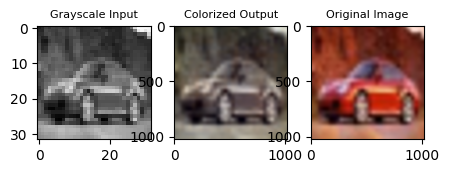

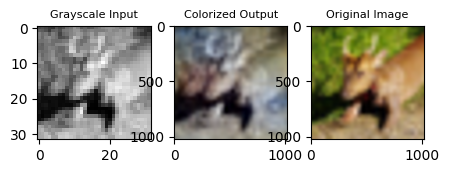

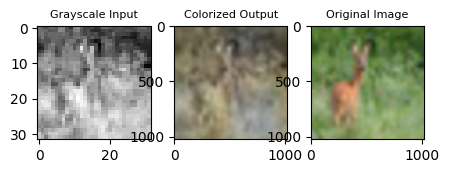

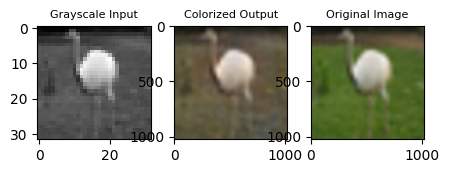

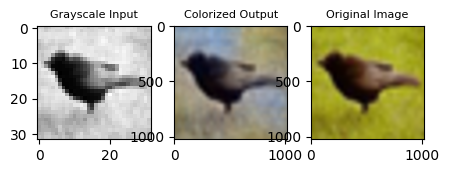

In [ ]:
# for i in range(len(X_test)):
for i in range(5):
  plt.figure(figsize=(5,5))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=8)
  plt.imshow( X_test[i].reshape((32,32)) , cmap='gray' )

  in_image = plt.subplot(3,3,2)
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=8)
  plt.imshow( image )

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( y_test[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Original Image', fontsize=8)
  plt.imshow( image )

  plt.show()

### Step 7: Plotting the results

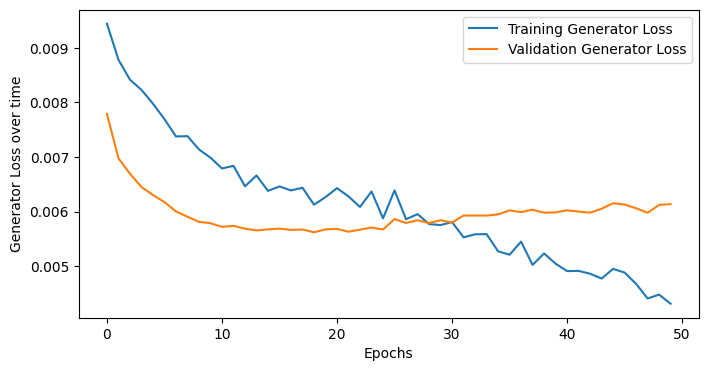

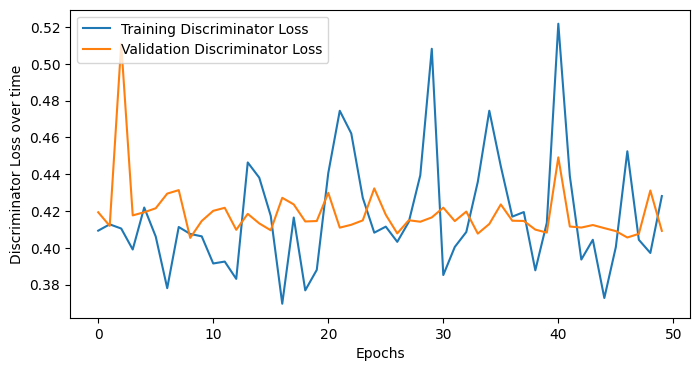

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss
plt.figure(figsize=(8, 4))
plt.plot(t_gen_loss, label='Training Generator Loss')
plt.plot(v_gen_loss, label='Validation Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Generator Loss over time')
plt.legend()
plt.show()

# Plot the accuracy
plt.figure(figsize=(8, 4))
plt.plot(t_disc_loss, label='Training Discriminator Loss')
plt.plot(v_disc_loss, label='Validation Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Discriminator Loss over time')
plt.legend()
plt.show()


## DC GAN Network Architecture 3 - UNET

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Step 1: Importing required libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import gc
%matplotlib inline

import tensorflow as tf
keras = tf.keras
import keras.layers as KL
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10

### Step 2: Data Loading and Data Preprocess

In [ ]:
def load_data():
    # Load CIFAR-10 dataset
    (train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

    # Split data into training and test sets
    train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

    # Further split training data into training and validation sets
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

    # Normalize the data
    train_data = train_data / 255.0
    val_data = val_data / 255.0
    test_data = test_data / 255.0

    gray_train_data = np.mean(train_data, axis=-1)
    gray_train_data = gray_train_data.reshape((*gray_train_data.shape, 1))

    gray_test_data = np.mean(test_data, axis=-1)
    # print(gray_test_data.shape)
    gray_test_data = gray_test_data.reshape((*gray_test_data.shape, 1))

    gray_val_data = np.mean(val_data, axis=-1)
    # print(gray_val_data.shape)
    gray_val_data = gray_val_data.reshape((*gray_val_data.shape, 1))

    print("Train dataset shape:", gray_train_data.shape)
    print("Validation dataset shape:", gray_val_data.shape)
    print("Test dataset shape:", gray_test_data.shape)

    return gray_train_data, gray_test_data, gray_val_data, train_data, test_data, val_data

gray_train_data, gray_test_data, gray_val_data, train_data, test_data, val_data = load_data()

170498071/170498071 [==============================] - 13s 0us/step
Train dataset shape: (32000, 32, 32, 1)
Validation dataset shape: (8000, 32, 32, 1)
Test dataset shape: (10000, 32, 32, 1)


### Step 3: Model Building - Defining Unet CNN

In [ ]:
def UNet():
    inputs = KL.Input(shape=[None, None, 1])
    conv1 = KL.Conv2D(64, (3, 3), padding='same')(inputs)
    conv1 = KL.BatchNormalization()(conv1)
    conv1 = KL.LeakyReLU(alpha=0.2)(conv1)
    conv1 = KL.Conv2D(64, (3, 3), strides=1, padding='same')(conv1)
    conv1 = KL.BatchNormalization()(conv1)
    conv1 = KL.LeakyReLU(alpha=0.2)(conv1)

    pool1 = KL.MaxPooling2D((2, 2), strides=2)(conv1)
    conv2 = KL.Conv2D(128, (3, 3), padding='same')(pool1)
    conv2 = KL.BatchNormalization()(conv2)
    conv2 = KL.LeakyReLU(alpha=0.2)(conv2)
    conv2 = KL.Conv2D(128, (3, 3), padding='same')(conv2)
    conv2 = KL.BatchNormalization()(conv2)
    conv2 = KL.LeakyReLU(alpha=0.2)(conv2)

    pool2 = KL.MaxPooling2D((2, 2), strides=2)(conv2)
    conv3 = KL.Conv2D(256, (3, 3), padding='same')(pool2)
    conv3 = KL.BatchNormalization()(conv3)
    conv3 = KL.LeakyReLU(alpha=0.2)(conv3)
    conv3 = KL.Conv2D(256, (3, 3), padding='same')(conv3)
    conv3 = KL.BatchNormalization()(conv3)
    conv3 = KL.LeakyReLU(alpha=0.2)(conv3)

    pool3 = KL.MaxPooling2D((2, 2), strides=2)(conv3)
    conv4 = KL.Conv2D(512, (3, 3), padding='same')(pool3)
    conv4 = KL.BatchNormalization()(conv4)
    conv4 = KL.LeakyReLU(alpha=0.2)(conv4)
    conv4 = KL.Conv2D(512, (3, 3), padding='same')(conv4)
    conv4 = KL.BatchNormalization()(conv4)
    conv4 = KL.LeakyReLU(alpha=0.2)(conv4)

    pool4 = KL.MaxPooling2D((2, 2), strides=2)(conv4)
    conv5 = KL.Conv2D(1024, (3, 3), padding='same')(pool4)
    conv5 = KL.BatchNormalization()(conv5)
    conv5 = KL.LeakyReLU(alpha=0.2)(conv5)
    conv5 = KL.Conv2D(1024, (3, 3), padding='same')(conv5)
    conv5 = KL.BatchNormalization()(conv5)
    conv5 = KL.LeakyReLU(alpha=0.2)(conv5)

    up6 = KL.Conv2DTranspose(512, (2, 2), strides=2)(conv5)
    up6 = KL.Concatenate()([conv4, up6])
    conv6 = KL.Conv2D(512, (3, 3), padding='same')(up6)
    conv6 = KL.BatchNormalization()(conv6)
    conv6 = KL.Activation('relu')(conv6)
    conv6 = KL.Conv2D(512, (3, 3), padding='same')(conv6)
    conv6 = KL.BatchNormalization()(conv6)
    conv6 = KL.Activation('relu')(conv6)

    up7 = KL.Conv2DTranspose(256, (2, 2), strides=2)(conv6)
    up7 = KL.Concatenate()([conv3, up7])
    conv7 = KL.Conv2D(256, (3, 3), padding='same')(up7)
    conv7 = KL.BatchNormalization()(conv7)
    conv7 = KL.Activation('relu')(conv7)
    conv7 = KL.Conv2D(256, (3, 3), padding='same')(conv7)
    conv7 = KL.BatchNormalization()(conv7)
    conv7 = KL.Activation('relu')(conv7)

    up8 = KL.Conv2DTranspose(128, (2, 2), strides=2)(conv7)
    up8 = KL.Concatenate()([conv2, up8])
    conv8 = KL.Conv2D(128, (3, 3), padding='same')(up8)
    conv8 = KL.BatchNormalization()(conv8)
    conv8 = KL.Activation('relu')(conv8)
    conv8 = KL.Conv2D(128, (3, 3), padding='same')(conv8)
    conv8 = KL.BatchNormalization()(conv8)
    conv8 = KL.Activation('relu')(conv8)

    up9 = KL.Conv2DTranspose(64, (2, 2), strides=2)(conv8)
    up9 = KL.Concatenate()([conv1, up9])
    conv9 = KL.Conv2D(64, (3, 3), padding='same')(up9)
    conv9 = KL.BatchNormalization()(conv9)
    conv9 = KL.Activation('relu')(conv9)
    conv9 = KL.Conv2D(64, (3, 3), padding='same')(conv9)
    conv9 = KL.BatchNormalization()(conv9)
    conv9 = KL.Activation('relu')(conv9)

    outputs = KL.Conv2D(3, (1, 1), strides=1)(conv9)
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
model = UNet()
model.compile('adam', loss='mean_squared_error', metrics=['mae', 'acc',])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   640         ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   256        ['conv2d[0][0]']                 
 alization)                     64)                                                           

In [ ]:
#Function to print sample images
def sample_batch(data, bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return idxs

def display_images(data, gray, nrow):
    idx = sample_batch(gray, bsize=nrow)
    gray_batch = gray[idx]
    color_batch = data[idx]
    images = model.predict(gray_batch)
    if np.var(images)!=0:
        images = (images-images.min())/(images.max()-images.min())
    cnt=1
    for i in range(nrow):
        plt.subplot(nrow, 3, cnt)
        if i == 0:
            plt.title("Original Image")
        plt.imshow(color_batch[i].reshape((32, 32, 3)), cmap="gray", interpolation='none')
        plt.subplot(nrow, 3, cnt + 1)
        if i == 0:
            plt.title("Grayscale Image")
        plt.imshow(gray_batch[i].reshape((32, 32)), cmap="gray", interpolation='none')
        plt.subplot(nrow, 3, cnt + 2)
        if i == 0:
            plt.title("Generated Image")
        plt.imshow(images[i].reshape((32, 32, 3)), cmap="gray", interpolation='none')
        cnt += 3
    plt.show()

### Step 4: Training the model

Epoch: 1 / 100
125/125 [==============================] - 6s 52ms/step - loss: 0.0434 - mae: 0.1083 - acc: 0.3725 - val_loss: 0.0697 - val_mae: 0.2116 - val_acc: 0.4171
Epoch: 2 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0071 - mae: 0.0604 - acc: 0.4052 - val_loss: 0.0452 - val_mae: 0.1734 - val_acc: 0.3815
Epoch: 3 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0065 - mae: 0.0567 - acc: 0.4172 - val_loss: 0.0294 - val_mae: 0.1408 - val_acc: 0.4241
Epoch: 4 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0063 - mae: 0.0551 - acc: 0.4256 - val_loss: 0.0148 - val_mae: 0.0991 - val_acc: 0.4243
Epoch: 5 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0062 - mae: 0.0549 - acc: 0.4302 - val_loss: 0.0072 - val_mae: 0.0639 - val_acc: 0.4529
Epoch: 6 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0060 - mae: 0.0538 - acc: 0.4399 - val_loss: 0.0057 - val_mae: 0.0531 - va

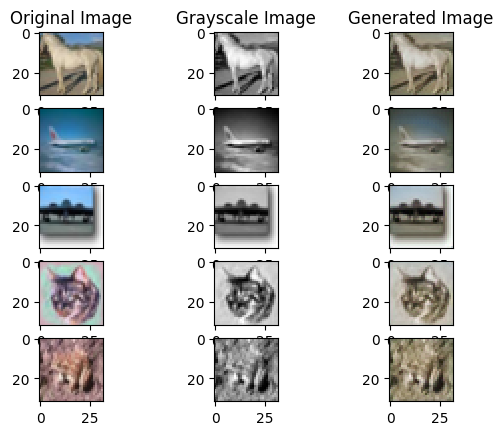

Epoch: 11 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0053 - mae: 0.0501 - acc: 0.5016 - val_loss: 0.0050 - val_mae: 0.0488 - val_acc: 0.4944
Epoch: 12 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0051 - mae: 0.0491 - acc: 0.5051 - val_loss: 0.0049 - val_mae: 0.0483 - val_acc: 0.5131
Epoch: 13 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0050 - mae: 0.0485 - acc: 0.5090 - val_loss: 0.0050 - val_mae: 0.0485 - val_acc: 0.4869
Epoch: 14 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0050 - mae: 0.0487 - acc: 0.5110 - val_loss: 0.0056 - val_mae: 0.0507 - val_acc: 0.5168
Epoch: 15 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0050 - mae: 0.0490 - acc: 0.5128 - val_loss: 0.0051 - val_mae: 0.0481 - val_acc: 0.4725
Epoch: 16 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0049 - mae: 0.0481 - acc: 0.5150 - val_loss: 0.0049 - val_mae: 0.047

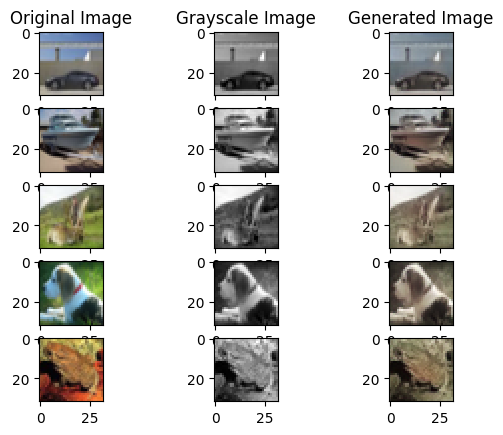

Epoch: 21 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0049 - mae: 0.0482 - acc: 0.5201 - val_loss: 0.0048 - val_mae: 0.0476 - val_acc: 0.5313
Epoch: 22 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0048 - mae: 0.0473 - acc: 0.5239 - val_loss: 0.0049 - val_mae: 0.0472 - val_acc: 0.5098
Epoch: 23 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0047 - mae: 0.0469 - acc: 0.5278 - val_loss: 0.0051 - val_mae: 0.0490 - val_acc: 0.5163
Epoch: 24 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0047 - mae: 0.0471 - acc: 0.5283 - val_loss: 0.0049 - val_mae: 0.0477 - val_acc: 0.5343
Epoch: 25 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0047 - mae: 0.0468 - acc: 0.5302 - val_loss: 0.0050 - val_mae: 0.0484 - val_acc: 0.5048
Epoch: 26 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0047 - mae: 0.0469 - acc: 0.5294 - val_loss: 0.0047 - val_mae: 0.046

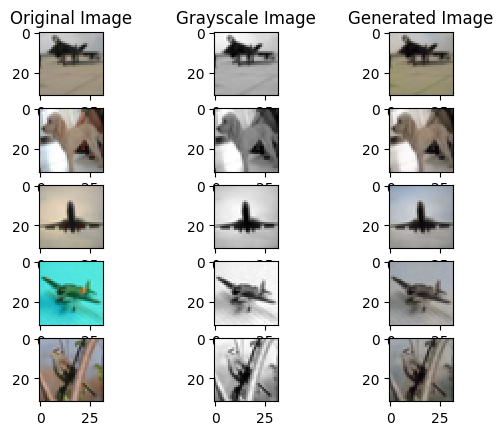

Epoch: 31 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0045 - mae: 0.0458 - acc: 0.5441 - val_loss: 0.0056 - val_mae: 0.0494 - val_acc: 0.5021
Epoch: 32 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0044 - mae: 0.0453 - acc: 0.5451 - val_loss: 0.0054 - val_mae: 0.0501 - val_acc: 0.5267
Epoch: 33 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0043 - mae: 0.0450 - acc: 0.5485 - val_loss: 0.0049 - val_mae: 0.0475 - val_acc: 0.5479
Epoch: 34 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0042 - mae: 0.0446 - acc: 0.5538 - val_loss: 0.0049 - val_mae: 0.0475 - val_acc: 0.5257
Epoch: 35 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0042 - mae: 0.0450 - acc: 0.5523 - val_loss: 0.0051 - val_mae: 0.0473 - val_acc: 0.4910
Epoch: 36 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0041 - mae: 0.0443 - acc: 0.5568 - val_loss: 0.0050 - val_mae: 0.047

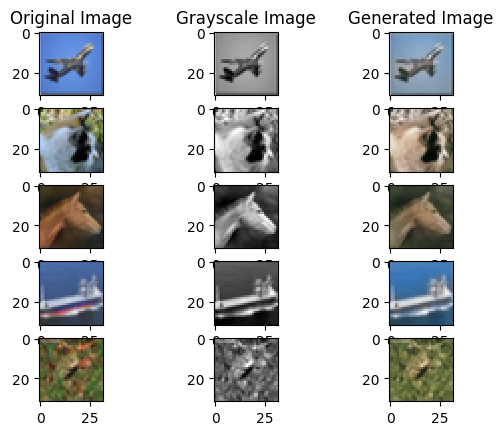

Epoch: 41 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0037 - mae: 0.0423 - acc: 0.5720 - val_loss: 0.0055 - val_mae: 0.0493 - val_acc: 0.5154
Epoch: 42 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0035 - mae: 0.0412 - acc: 0.5751 - val_loss: 0.0055 - val_mae: 0.0492 - val_acc: 0.5295
Epoch: 43 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0034 - mae: 0.0407 - acc: 0.5789 - val_loss: 0.0048 - val_mae: 0.0460 - val_acc: 0.5361
Epoch: 44 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0033 - mae: 0.0404 - acc: 0.5831 - val_loss: 0.0054 - val_mae: 0.0494 - val_acc: 0.5245
Epoch: 45 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0032 - mae: 0.0393 - acc: 0.5854 - val_loss: 0.0048 - val_mae: 0.0460 - val_acc: 0.5463
Epoch: 46 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0030 - mae: 0.0384 - acc: 0.5938 - val_loss: 0.0048 - val_mae: 0.045

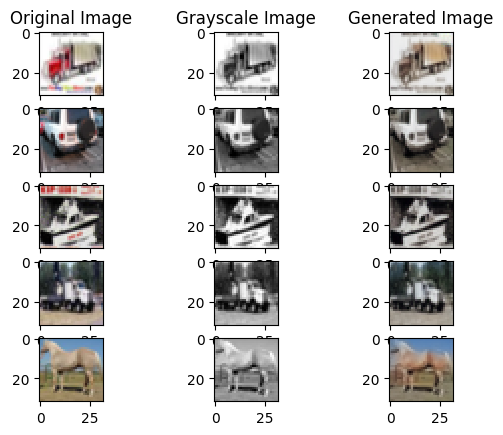

Epoch: 51 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0026 - mae: 0.0359 - acc: 0.6131 - val_loss: 0.0049 - val_mae: 0.0478 - val_acc: 0.5095
Epoch: 52 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0025 - mae: 0.0351 - acc: 0.6142 - val_loss: 0.0050 - val_mae: 0.0480 - val_acc: 0.5217
Epoch: 53 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0025 - mae: 0.0348 - acc: 0.6173 - val_loss: 0.0050 - val_mae: 0.0477 - val_acc: 0.5151
Epoch: 54 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0024 - mae: 0.0346 - acc: 0.6234 - val_loss: 0.0054 - val_mae: 0.0489 - val_acc: 0.5118
Epoch: 55 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0024 - mae: 0.0345 - acc: 0.6256 - val_loss: 0.0050 - val_mae: 0.0478 - val_acc: 0.5086
Epoch: 56 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0023 - mae: 0.0341 - acc: 0.6274 - val_loss: 0.0049 - val_mae: 0.047

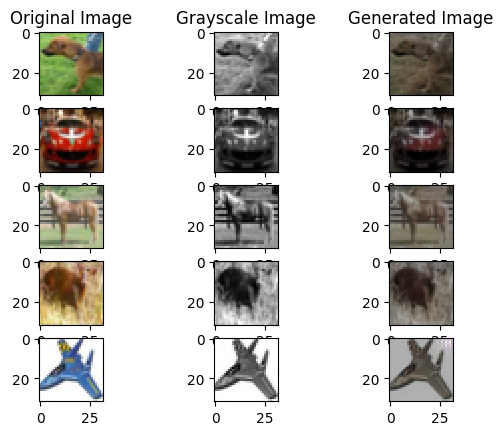

Epoch: 61 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0021 - mae: 0.0323 - acc: 0.6528 - val_loss: 0.0051 - val_mae: 0.0492 - val_acc: 0.5347
Epoch: 62 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0020 - mae: 0.0318 - acc: 0.6568 - val_loss: 0.0055 - val_mae: 0.0501 - val_acc: 0.5278
Epoch: 63 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0020 - mae: 0.0315 - acc: 0.6604 - val_loss: 0.0051 - val_mae: 0.0471 - val_acc: 0.5232
Epoch: 64 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0019 - mae: 0.0307 - acc: 0.6672 - val_loss: 0.0053 - val_mae: 0.0502 - val_acc: 0.5326
Epoch: 65 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0019 - mae: 0.0304 - acc: 0.6708 - val_loss: 0.0053 - val_mae: 0.0491 - val_acc: 0.5427
Epoch: 66 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0018 - mae: 0.0301 - acc: 0.6762 - val_loss: 0.0052 - val_mae: 0.049

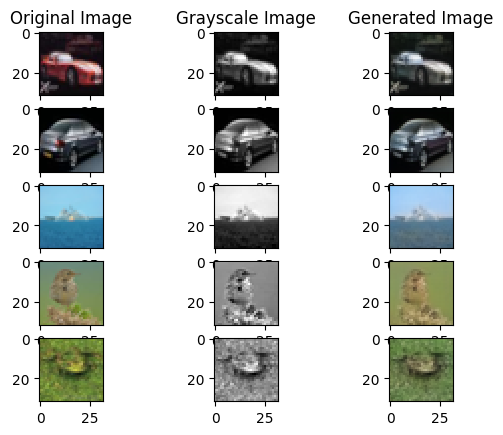

Epoch: 71 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0016 - mae: 0.0289 - acc: 0.6883 - val_loss: 0.0055 - val_mae: 0.0509 - val_acc: 0.5373
Epoch: 72 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0016 - mae: 0.0282 - acc: 0.6946 - val_loss: 0.0052 - val_mae: 0.0473 - val_acc: 0.5563
Epoch: 73 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0016 - mae: 0.0282 - acc: 0.6992 - val_loss: 0.0065 - val_mae: 0.0518 - val_acc: 0.5415
Epoch: 74 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0015 - mae: 0.0274 - acc: 0.7024 - val_loss: 0.0051 - val_mae: 0.0483 - val_acc: 0.5594
Epoch: 75 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0015 - mae: 0.0273 - acc: 0.7043 - val_loss: 0.0054 - val_mae: 0.0508 - val_acc: 0.4624
Epoch: 76 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0014 - mae: 0.0271 - acc: 0.7083 - val_loss: 0.0052 - val_mae: 0.050

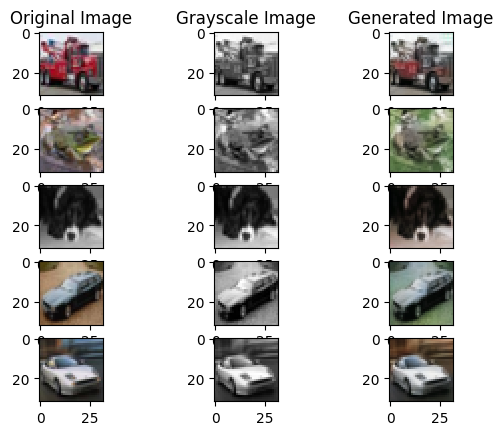

Epoch: 81 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0013 - mae: 0.0261 - acc: 0.7166 - val_loss: 0.0051 - val_mae: 0.0478 - val_acc: 0.5342
Epoch: 82 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0013 - mae: 0.0260 - acc: 0.7197 - val_loss: 0.0053 - val_mae: 0.0508 - val_acc: 0.5425
Epoch: 83 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0012 - mae: 0.0249 - acc: 0.7244 - val_loss: 0.0049 - val_mae: 0.0479 - val_acc: 0.5121
Epoch: 84 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0012 - mae: 0.0250 - acc: 0.7271 - val_loss: 0.0049 - val_mae: 0.0471 - val_acc: 0.5264
Epoch: 85 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0012 - mae: 0.0249 - acc: 0.7289 - val_loss: 0.0054 - val_mae: 0.0520 - val_acc: 0.5370
Epoch: 86 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0012 - mae: 0.0253 - acc: 0.7291 - val_loss: 0.0051 - val_mae: 0.050

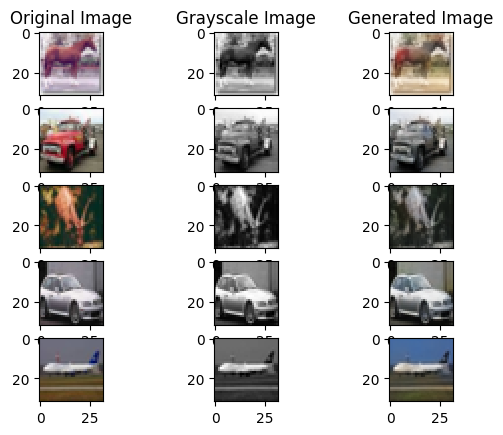

Epoch: 91 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0011 - mae: 0.0236 - acc: 0.7391 - val_loss: 0.0050 - val_mae: 0.0475 - val_acc: 0.5408
Epoch: 92 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0011 - mae: 0.0235 - acc: 0.7408 - val_loss: 0.0049 - val_mae: 0.0478 - val_acc: 0.5176
Epoch: 93 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0011 - mae: 0.0234 - acc: 0.7418 - val_loss: 0.0050 - val_mae: 0.0483 - val_acc: 0.5119
Epoch: 94 / 100
125/125 [==============================] - 5s 42ms/step - loss: 0.0011 - mae: 0.0235 - acc: 0.7422 - val_loss: 0.0049 - val_mae: 0.0471 - val_acc: 0.5499
Epoch: 95 / 100
125/125 [==============================] - 5s 42ms/step - loss: 9.9252e-04 - mae: 0.0226 - acc: 0.7452 - val_loss: 0.0049 - val_mae: 0.0466 - val_acc: 0.5409
Epoch: 96 / 100
125/125 [==============================] - 5s 43ms/step - loss: 0.0010 - mae: 0.0231 - acc: 0.7455 - val_loss: 0.0049 - val_mae: 0

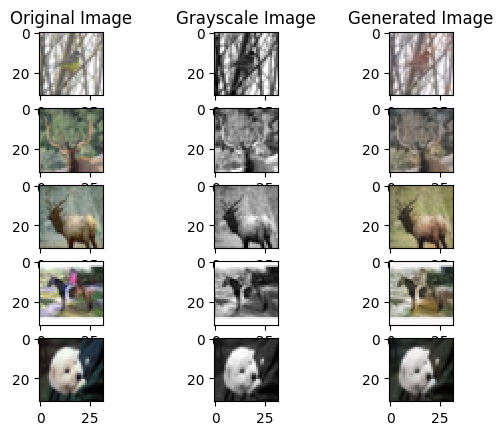

In [ ]:
from IPython import display

# Training loop
loss = []
accuracy=[]
mae=[]

val_loss=[]
val_accuracy=[]
val_mae = []

num_epochs = 100
for epoch in range(1, num_epochs+1):
    print('Epoch:', epoch,'/',num_epochs)
    history = model.fit(gray_train_data, train_data, batch_size=256, validation_data=(gray_val_data, val_data))

    # Get the training and validation loss values
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])

    # Get the training and validation maccuracy values
    accuracy.append(history.history['acc'])
    val_accuracy.append(history.history['val_acc'])

    # Get the training and validation mae values
    mae.append(history.history["mae"])
    val_mae.append(history.history["val_mae"])

    if epoch%10==0:
      display_images(val_data, gray_val_data, 5)

    # if epoch%5==0:
    #   display.clear_output(wait=True)


model.save('unet.hdf5')

### Step 5:  Testing the model

In [ ]:
# Testing
test_loss, test_accuracy, test_mae = model.evaluate(gray_test_data, test_data, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test MAE:", test_mae)

# print("Test Accuracy : ", history.history['acc'], "Test Loss : ", history.history['loss'])

313/313 [==============================] - 2s 6ms/step - loss: 0.0051 - mae: 0.0490 - acc: 0.5375
Test Loss: 0.005070398561656475
Test Accuracy: 0.04895390197634697
Test MAE: 0.5374830961227417


### Step 6: Plotting training and validation metrics

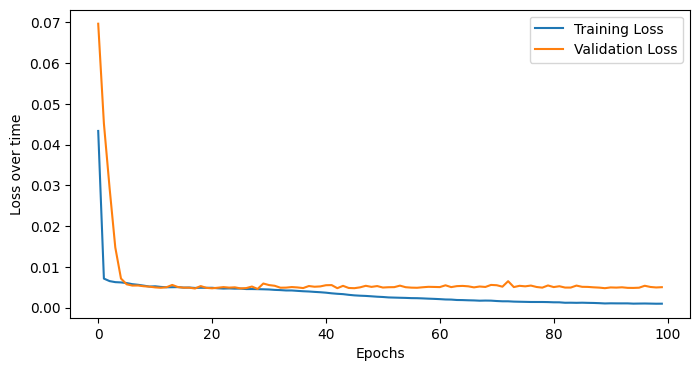

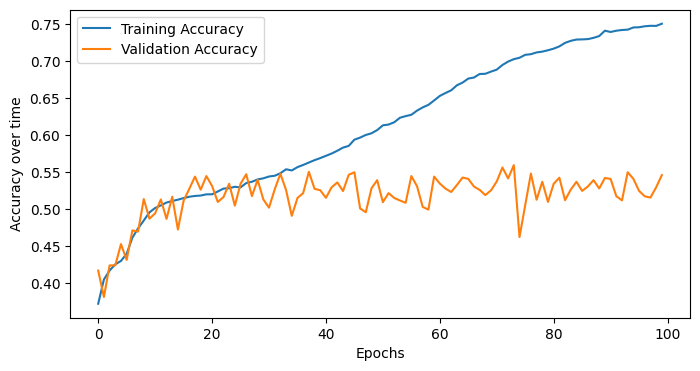

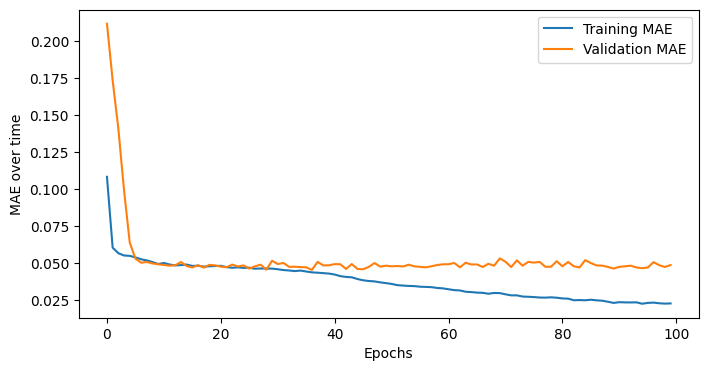

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss
plt.figure(figsize=(8, 4))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss over time')
plt.legend()
plt.show()


# Plot the accuracy
plt.figure(figsize=(8, 4))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy over time')
plt.legend()
plt.show()

# Plot the accuracy
plt.figure(figsize=(8, 4))
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE over time')
plt.legend()
plt.show()